In [1]:
from shapely.geometry import Polygon  
from shapely import affinity    
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from utils import SensorCamera, CoverageNode, Tree
from utils import lawmowerPath
import random

random.seed(42)  # For reproducibility

DJImini3Camera = SensorCamera()
desirableGSD = 1*0.43 #cm/px
altitude = DJImini3Camera.h_desirable(desirableGSD)/100
width,height = DJImini3Camera.l(altitude) # dimensão horizontal do sensor para a altitude desejada
L = 6
poly = Polygon([(-L*height, -L*width), (L*height, -L*width), (L*height, L*width), (-L*height, L*width)])
angle_deg = 0  # ângulo da varredura em graus (0 = horizontal, 90 = vertical)
waypointsLawMower = lawmowerPath(poly, height, width, angle_deg)

areas_de_interesse = []
base = Polygon([(-0.1*height*L, -0.1*width*L), (0.1*height*L,-0.1*width*L), (0.1*height*L,0.1*width*L), (-0.1*height*L,0.1*width*L)])

p = 10 # proporção de área de interesse em relação à área total
c = 8 # número de patches de interesse
base = affinity.scale(base,np.sqrt(p/c), np.sqrt(p/c), origin=(0, 0))
cont = 0
while len(areas_de_interesse) < c:
    cont += 1
    if cont > 1000:
        cont = 0
        areas_de_interesse = []
    i = random.uniform(-1 + np.sqrt(p/c)*0.1, 1 - np.sqrt(p/c)*0.1)
    j = random.uniform(-1 + np.sqrt(p/c)*0.1, 1 - np.sqrt(p/c)*0.1)     
    poly_rand = affinity.translate(base, i*L*height, j*L*width)
    if(not any(p.intersects(poly_rand) for p in areas_de_interesse)):
        areas_de_interesse.append(poly_rand)
              
interesting_area = 0
for area in areas_de_interesse:
    interesting_area += poly.intersection(base).area
interesting_area = interesting_area /poly.area
print("p =", np.round(interesting_area * 100,2), "%", "interesting")
print("C =", len(areas_de_interesse), "patches")


p = 10.0 % interesting
C = 8 patches


In [2]:
from utils import Shortcut, DeepFirst, BreadthFirst

altitude2 = DJImini3Camera.h_desirable(4*desirableGSD)/100
width2,height2 = DJImini3Camera.l(altitude2) # dimensão horizontal do sensor para a altitude desejada
waypointsInitial = lawmowerPath(poly, height2, width2, angle_deg)

LawnmowerTree = Tree(sensorCamera=DJImini3Camera)
BFTree = BreadthFirst(DJImini3Camera,areas_de_interesse)
ShortTree = Shortcut(DJImini3Camera,areas_de_interesse)
DFTree = DeepFirst(DJImini3Camera,areas_de_interesse)

LawnmowerTree.add_fistLevel_nodes(waypointsLawMower, altitude,width,height)
BFTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)
DFTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)
ShortTree.add_fistLevel_nodes(waypointsInitial, altitude2,width2,height2)

In [3]:
from matplotlib.colors import LinearSegmentedColormap
cmap_custom = LinearSegmentedColormap.from_list(
    "azul_verde_vermelho",
    [(0.0, "blue"), (0.5, "green"), (1.0, "red")]
)

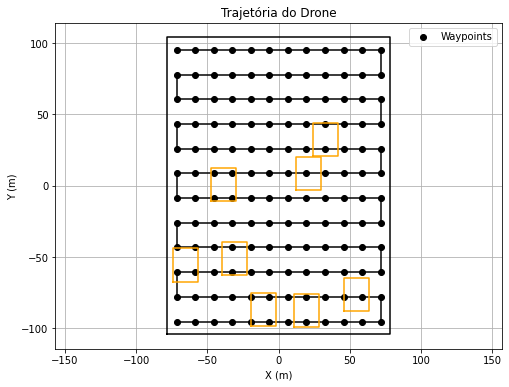

Coverage Path length (LawMower):  1.907136000000005  km


In [4]:
waypoints = np.array(waypointsLawMower)
fig, ax = plt.subplots(figsize=(8, 6))
waypoints_x = [wp[0] for wp in waypoints]
waypoints_y = [wp[1] for wp in waypoints]
ax.scatter(waypoints_x, waypoints_y, color='black', label='Waypoints', marker='o')
ax.plot(waypoints_x, waypoints_y, color='black')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black')
for area in areas_de_interesse:
    x, y = area.exterior.xy
    ax.plot(x, y, color='Orange')
plt.title('Trajetória do Drone')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()
path_length = 0
for i in range(np.size(waypoints,0)-1):
    path_length += np.linalg.norm(waypoints[i+1] - waypoints[i])
print("Coverage Path length (LawMower): ", path_length/1000, " km")

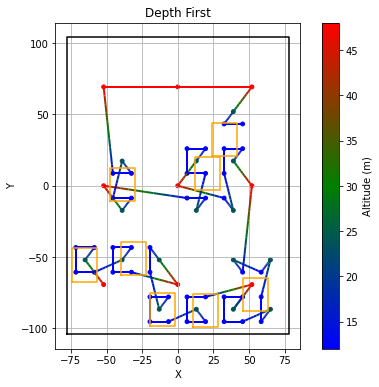

Coverage Path length (Depth First):  1.570118796198341  km


In [5]:
waypointsDF = np.array(DFTree.generate_path())

# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypointsDF) - 1):
    segment = interp_segment(waypointsDF[i], waypointsDF[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypointsDF[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.scatter(waypointsDF[:, 0], waypointsDF[:, 1], c=waypointsDF[:,2], cmap=cmap_custom, s=15)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black',alpha=0.1)
for area_de_interesse in areas_de_interesse:
    x, y = area_de_interesse.exterior.xy
    plt.plot(x, y, color='orange')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Depth First")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length = 0
for i in range(np.size(waypointsDF,0)-1):
    path_length += np.linalg.norm(waypointsDF[i+1] - waypointsDF[i])
print("Coverage Path length (Depth First): ", path_length/1000, " km")

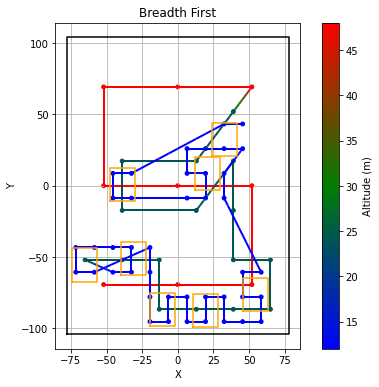

Coverage Path length (Breadth First):  1.7960870574290388  km


In [6]:
waypointsBF = np.array(BFTree.generate_path())
# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypointsBF) - 1):
    segment = interp_segment(waypointsBF[i], waypointsBF[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypointsBF[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.scatter(waypointsBF[:, 0], waypointsBF[:, 1], c=waypointsBF[:,2], cmap=cmap_custom, s=15)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black',alpha=0.1)
for area_de_interesse in areas_de_interesse:
    x, y = area_de_interesse.exterior.xy
    plt.plot(x, y, color='orange')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Breadth First")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length = 0
for i in range(np.size(waypointsBF,0)-1):
    path_length += np.linalg.norm(waypointsBF[i+1] - waypointsBF[i])
print("Coverage Path length (Breadth First): ", path_length/1000, " km")

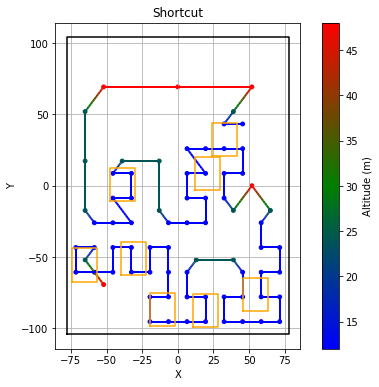

Coverage Path length (Shortcut):  1.3605994518994367  km


In [7]:
waypointsSC = np.array(ShortTree.generate_path())
# Parâmetros
n_interp = 10  # pontos intermediários entre cada par

# Função para interpolar entre dois pontos
def interp_segment(p1, p2, n):
    return np.linspace(p1, p2, n, endpoint=False)

# Interpolar todos os segmentos
interp_points = []
for i in range(len(waypointsSC) - 1):
    segment = interp_segment(waypointsSC[i], waypointsSC[i + 1], n_interp)
    interp_points.append(segment)

# Adiciona o último ponto
interp_points.append(waypointsSC[-1][None, :])
# Empacota tudo
interp_points = np.vstack(interp_points)  # (M, 3)
xy = interp_points[:, :2]
z = interp_points[:, 2]

# Criar segmentos suaves
points = xy.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
z_segment = (z[:-1] + z[1:]) / 2

# Plotando
lc = LineCollection(segments, cmap=cmap_custom, array=z_segment, linewidth=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.scatter(waypointsSC[:, 0], waypointsSC[:, 1], c=waypointsSC[:,2], cmap=cmap_custom, s=15)
plt.colorbar(lc, ax=ax, label='Altitude (m)')
x, y = poly.exterior.xy
ax.plot(x, y, color='black')
if poly.interiors:
    for interior in poly.interiors:
        x, y = interior.xy
        ax.plot(x, y, color='black',alpha=0.1)
for area_de_interesse in areas_de_interesse:
    x, y = area_de_interesse.exterior.xy
    plt.plot(x, y, color='orange')

ax.plot()
ax.set_aspect('equal')
ax.grid(True)
plt.title("Shortcut")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
path_length = 0
for i in range(np.size(waypointsSC,0)-1):
    path_length += np.linalg.norm(waypointsSC[i+1] - waypointsSC[i])
print("Coverage Path length (Shortcut): ", path_length/1000, " km")